## Assignment 2.3: Text classification via RNN (30 points)

In this assignment you will perform sentiment analysis of the IMDBs reviews by using RNN. An additional goal is to learn high abstactions of the **torchtext** module that consists of data processing utilities and popular datasets for natural language.

In [0]:
import pandas as pd
import numpy as np
import torch

from torchtext import datasets

from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.3)

### Preparing Data

In [0]:
TEXT = Field(sequential=True, lower=True)
LABEL = LabelField()

In [0]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split()

In [43]:
%%time
TEXT.build_vocab(trn)

CPU times: user 1.25 s, sys: 25 ms, total: 1.27 s
Wall time: 1.28 s


In [0]:
LABEL.build_vocab(trn)

The vocab.freqs is a collections.Counter object, so we can take a look at the most frequent words.

In [45]:
TEXT.vocab.freqs.most_common(10)

[('the', 225144),
 ('a', 111893),
 ('and', 110712),
 ('of', 100624),
 ('to', 93441),
 ('is', 72511),
 ('in', 63342),
 ('i', 49350),
 ('this', 48499),
 ('that', 46229)]

### Creating the Iterator (2 points)

During training, we'll be using a special kind of Iterator, called the **BucketIterator**. When we pass data into a neural network, we want the data to be padded to be the same length so that we can process them in batch:

e.g.
\[ 
\[3, 15, 2, 7\],
\[4, 1\], 
\[5, 5, 6, 8, 1\] 
\] -> \[ 
\[3, 15, 2, 7, **0**\],
\[4, 1, **0**, **0**, **0**\], 
\[5, 5, 6, 8, 1\] 
\] 

If the sequences differ greatly in length, the padding will consume a lot of wasteful memory and time. The BucketIterator groups sequences of similar lengths together for each batch to minimize padding.

Complete the definition of the **BucketIterator** object

In [0]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(64, 64, 64),
        sort=True,
        # we don't need to specify sort_key because it is set implicitly in Example object
        sort_within_batch=False,
        device='cuda',
#         device='cpu',
        repeat=False
)

Let's take a look at what the output of the BucketIterator looks like. Do not be suprised **batch_first=True**

In [47]:
len(TEXT.vocab)

202820

In [48]:
batch = next(train_iter.__iter__()); batch.text

tensor([[  29,   50,    9,  ...,    9,  572,    9],
        [  81, 1166,   14,  ...,  456,   50,  199],
        [  10,   47, 2418,  ...,  199,    3,   10],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')

The batch has all the fields we passed to the Dataset as attributes. The batch data can be accessed through the attribute with the same name.

In [49]:
batch.__dict__.keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'text', 'label'])

### Define the RNN-based text classification model (10 points)

Start simple first. Implement the model according to the shema below.  
![alt text](https://miro.medium.com/max/1396/1*v-tLYQCsni550A-hznS0mw.jpeg)


In [0]:
class RNNBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim):
        super().__init__()
        self.emb = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=False)
        self.linear = nn.Linear(hidden_dim, 1)
            
    def forward(self, seq):
        embeddings = self.emb(seq)
        last_hidden = self.rnn(embeddings)[1]
        # preds are outputs of linear layer BEFORE sigmoid
        preds = self.linear(last_hidden).reshape(-1)
        return preds

In [57]:
em_sz = 200
nh = 300
model = RNNBaseline(nh, emb_dim=em_sz); model

RNNBaseline(
  (emb): Embedding(202820, 200)
  (rnn): GRU(200, 300)
  (linear): Linear(in_features=300, out_features=1, bias=True)
)

If you're using a GPU, remember to call model.cuda() to move your model to the GPU.

In [58]:
model.cuda()

RNNBaseline(
  (emb): Embedding(202820, 200)
  (rnn): GRU(200, 300)
  (linear): Linear(in_features=300, out_features=1, bias=True)
)

### The training loop (3 points)

Define the optimization and the loss functions.

In [0]:
learning_rate = 1e-3
opt = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.BCEWithLogitsLoss()

Define the stopping criteria.

In [0]:
epochs = 25

In [0]:
def train_loop():
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        running_corrects = 0
        model.train() 
        for batch in train_iter:           
            x = batch.text
            y = batch.label

            opt.zero_grad()
            preds = model(x)
            loss = loss_func(preds, y.float())
            loss.backward()
            opt.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(trn)
        train_loss_history.append(epoch_loss)

        val_loss = 0.0
        model.eval()
        for batch in val_iter:
            x = batch.text
            y = batch.label

            preds = model(x) 
            loss = loss_func(preds, y.float())
            val_loss += loss.item()
          
        val_loss /= len(vld)
        valid_loss_history.append(val_loss)
        print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(
          epoch, epoch_loss, val_loss))

In [61]:
%%time

train_loss_history = []
valid_loss_history = []

train_loop()

Epoch: 1, Training Loss: 0.010951032982553755, Validation Loss: 0.010909023213386536
Epoch: 2, Training Loss: 0.01079215990134648, Validation Loss: 0.010746264251073202
Epoch: 3, Training Loss: 0.009350192928314209, Validation Loss: 0.008579478259881337
Epoch: 4, Training Loss: 0.004811991492339543, Validation Loss: 0.007020445138216019
Epoch: 5, Training Loss: 0.0019441222961992025, Validation Loss: 0.008584113729000092
Epoch: 6, Training Loss: 0.0007047856861991541, Validation Loss: 0.010602376333872477
Epoch: 7, Training Loss: 0.00037709978071174454, Validation Loss: 0.012323990674813589
Epoch: 8, Training Loss: 0.00016102776816447398, Validation Loss: 0.015453861232598622
Epoch: 9, Training Loss: 0.0002321602637846289, Validation Loss: 0.011648448757330577
Epoch: 10, Training Loss: 0.0002583252216689289, Validation Loss: 0.014609677033343663
Epoch: 11, Training Loss: 9.73685407096387e-05, Validation Loss: 0.014716361463814973
Epoch: 12, Training Loss: 0.00010980532141651825, Valida

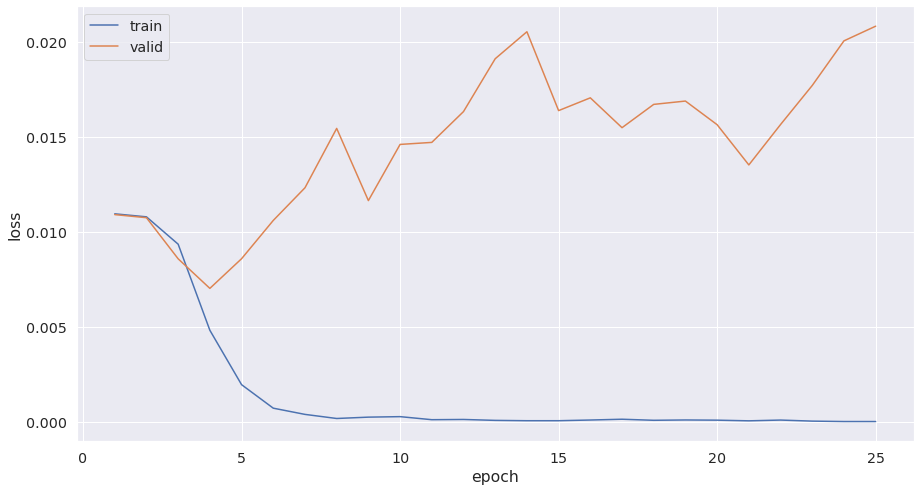

In [62]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(epochs) + 1, train_loss_history, label='train')
plt.plot(np.arange(epochs) + 1, valid_loss_history, label='valid')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

It seems that model is overfitting: loss on train is close to zero while loss on validation is increasing. Let's reduce `epochs` to $4$.

In [0]:
em_sz = 200
nh = 300
model = RNNBaseline(nh, emb_dim=em_sz)
model.cuda()
learning_rate = 1e-3
opt = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.BCEWithLogitsLoss()
epochs = 4

In [64]:
%%time

train_loss_history = []
valid_loss_history = []

train_loop()

Epoch: 1, Training Loss: 0.010970963273729597, Validation Loss: 0.01090689890384674
Epoch: 2, Training Loss: 0.010694666007586888, Validation Loss: 0.010977012586593627
Epoch: 3, Training Loss: 0.009757140828881945, Validation Loss: 0.010471367144584656
Epoch: 4, Training Loss: 0.006684399534123284, Validation Loss: 0.006333266405264537
CPU times: user 1min 42s, sys: 32.7 s, total: 2min 14s
Wall time: 2min 16s


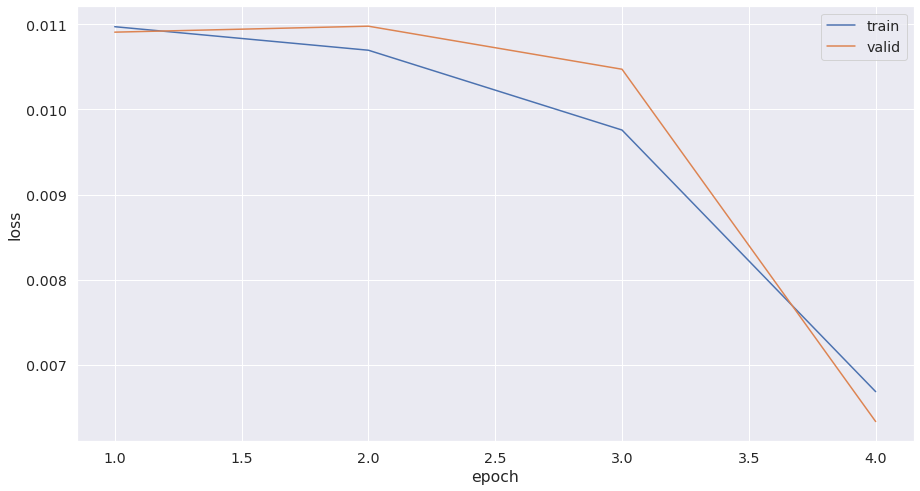

In [65]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(epochs) + 1, train_loss_history, label='train')
plt.plot(np.arange(epochs) + 1, valid_loss_history, label='valid')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Calculate performance of the trained model (5 points)

In [0]:
y_pred = []
y_true = []
model.eval()

for batch in test_iter:
    x = batch.text
    y = batch.label

    y_pred += list((torch.sigmoid(model(x)) >= 0.5).detach().cpu().numpy())
    y_true += list((y.detach().cpu().numpy()))

In [84]:
print(accuracy_score(y_true, y_pred))
print(precision_score(y_true, y_pred))
print(recall_score(y_true, y_pred))
print(f1_score(y_true, y_pred))

0.83196
0.8336415534292836
0.82944
0.8315354693828448


Write down the calculated performance

### Accuracy: 0.83196
### Precision: 0.8336
### Recall: 0.82944
### F1: 0.8315

### Experiments (10 points)

Experiment with the model and achieve better results. You can find advices [here](https://arxiv.org/abs/1801.06146). Implement and describe your experiments in details, mention what was helpful.

### 1. WORK IN PROGRESS
### 2. ?
### 3. ?